In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tnrange, tqdm_notebook
import gc

In [2]:
sns.set_context('talk')

# Read the data

In [3]:
dfXtrain = pd.read_csv('preprocessed_csv/train.csv', index_col='id')
dfXtest = pd.read_csv('preprocessed_csv/test.csv', index_col='id')
dfYtrain = pd.read_csv('preprocessed_csv/y_train.csv', header=None, names=['INDEX', 'P_TARGET_FLAG'])

In [4]:
x_train = np.array(dfXtrain)
x_test = np.array(dfXtest)

y_train = np.array(dfYtrain['P_TARGET_FLAG'])

# Save routines

In [5]:
dfYtest = pd.DataFrame({'INDEX': dfXtest.index, 'P_TARGET_FLAG': np.zeros(x_test.shape[0])})
dfYtest.head()

,INDEX,P_TARGET_FLAG
0,3,0.0
1,9,0.0
2,10,0.0
3,18,0.0
4,21,0.0


In [6]:
def save_to_file(y, file_name):
    dfYtest['P_TARGET_FLAG'] = y
    dfYtest.to_csv('results/{}'.format(file_name), index=False)

# Train RF

In [7]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import ExtraTreesClassifier as ETC
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split

In [8]:
x_subtrain, x_subtest, y_subtrain, y_subtest = train_test_split(x_train, y_train, 
                                                                test_size=0.15, random_state=42,
                                                                stratify=y_train)

In [9]:
def get_score_list(X, y, clf, scorer):
    predictions = list()
    score = list()
    for i, tree in enumerate(clf.estimators_):
        proba = tree.predict_proba(X)[:, 1]
        predictions.append(proba)
        rf_prediction = np.mean(predictions, axis=0)
        score.append(scorer(y, rf_prediction))
    return score

In [11]:
def plot_score_graph(clf, X_train, X_test, y_train, y_test, scorer, prefix, print_train=True):
    clf.fit(X_train, y_train)
    if print_train:
        train_score = get_score_list(X_train, y_train, clf, scorer)
    test_score = get_score_list(X_test, y_test, clf, scorer)
    if print_train:
        plt.plot(train_score, label=prefix + ' train set error')
    plt.plot(test_score, label=prefix + ' test set error')
    plt.xlabel('n_estimators')
    plt.ylabel('score')
    plt.legend()
    return test_score, clf

In [18]:
def combine_rfs(rf_a, rf_b):
    rf_a.estimators_ += rf_b.estimators_
    rf_a.n_estimators = len(rf_a.estimators_)
    return rf_a

CPU times: user 1min 42s, sys: 8.95 s, total: 1min 51s
Wall time: 59.4 s


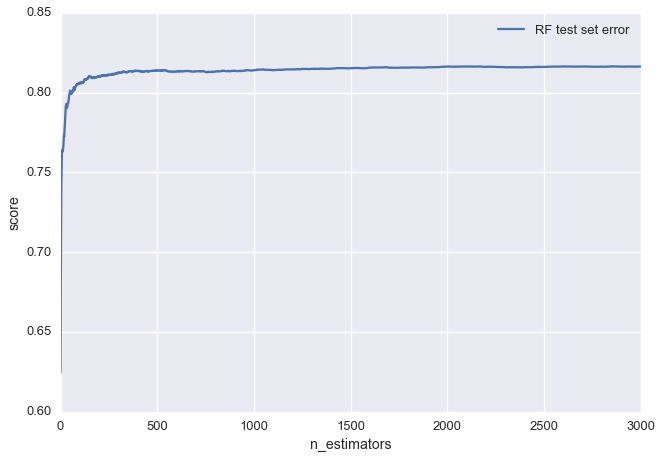

In [12]:
%%time

n_estimators = 3000
test_score, clf = plot_score_graph(RFC(n_estimators=n_estimators, criterion='entropy', n_jobs=-1, random_state=42),
                                   x_subtrain, x_subtest, y_subtrain, y_subtest, roc_auc_score,
                                   prefix='RF', print_train=False)

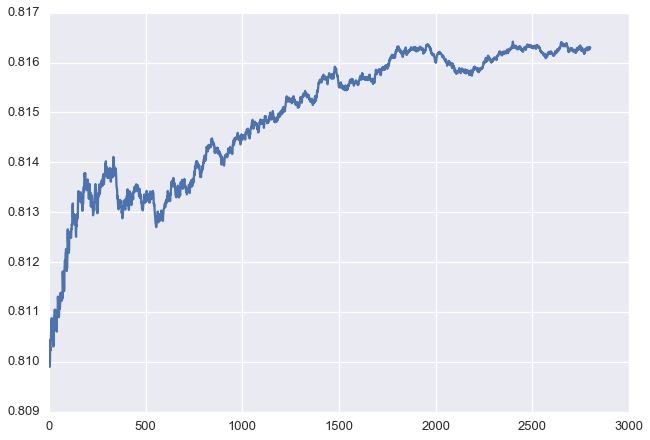

In [27]:
plt.plot(test_score[200:])

In [28]:
%%time

n_estimators = 1000

clf = RFC(n_estimators=n_estimators, class_weight='balanced', criterion='entropy', n_jobs=-1, random_state=42)
clf.fit(x_subtrain, y_subtrain)

balanced_test_score = get_score_list(x_subtest, y_subtest, clf, roc_auc_score)

CPU times: user 30.7 s, sys: 118 ms, total: 30.8 s
Wall time: 13.2 s


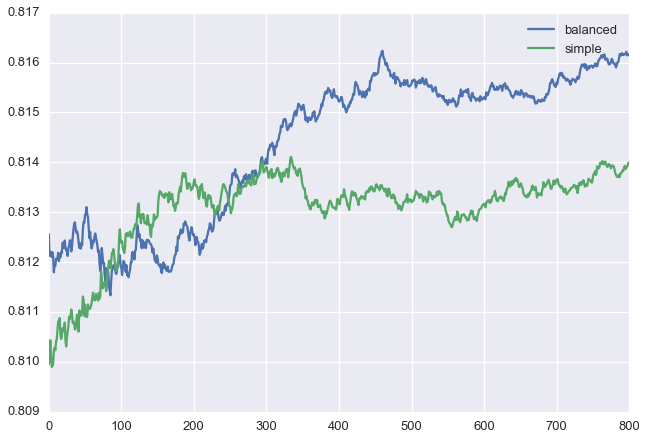

In [31]:
plt.plot(balanced_test_score[200:], label='balanced')
plt.plot(test_score[200:1000], label='simple')
plt.legend()

balanced лучше на 0.002

In [33]:
%%time

kwargs = {'n_estimators': 1000, 'class_weight': 'balanced', 'criterion': 'entropy', 'n_jobs': -1, 'random_state': 42}
max_features_test_score = []
max_features_range = [3, 7, 10, 15, 20, 27]

for max_features in tqdm_notebook(max_features_range, desc='max_features'):
    clf = RFC(max_features = max_features, **kwargs)
    clf.fit(x_subtrain, y_subtrain)
    max_features_test_score.append(get_score_list(x_subtest, y_subtest, clf, roc_auc_score))


CPU times: user 5min 22s, sys: 599 ms, total: 5min 23s
Wall time: 1min 46s


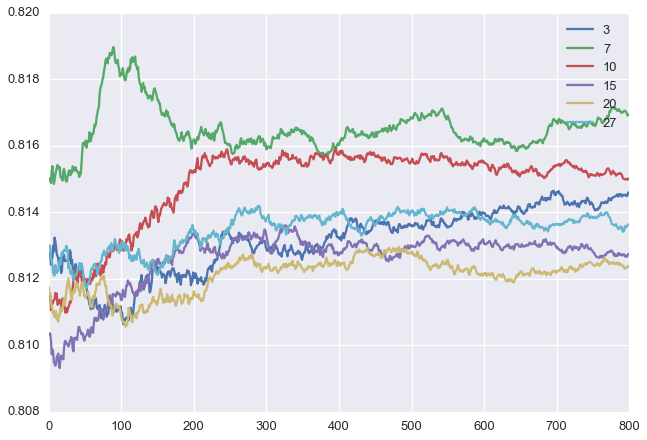

In [36]:
for index, max_features in enumerate(max_features_range):
    plt.plot(max_features_test_score[index][200:], label=max_features)

plt.legend()

In [37]:
%%time

kwargs = {'n_estimators': 1000, 'class_weight': 'balanced', 'criterion': 'entropy', 'n_jobs': -1, 'random_state': 42}
max_features_test_score_second = []
max_features_range_second = list(range(3, 11))

for max_features in tqdm_notebook(max_features_range_second, desc='max_features'):
    clf = RFC(max_features = max_features, **kwargs)
    clf.fit(x_subtrain, y_subtrain)
    max_features_test_score_second.append(get_score_list(x_subtest, y_subtest, clf, roc_auc_score))


CPU times: user 4min 25s, sys: 983 ms, total: 4min 26s
Wall time: 1min 41s


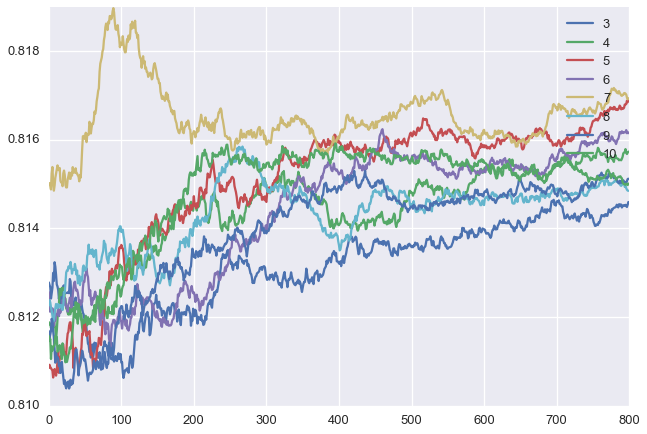

In [38]:
for index, max_features in enumerate(max_features_range_second):
    plt.plot(max_features_test_score_second[index][200:], label=max_features)

plt.legend()

best max_features = 7

In [49]:
%%time

kwargs = {'n_estimators': 1000, 'class_weight': 'balanced', 'max_features': 7,
          'criterion': 'entropy', 'n_jobs': -1, 'random_state': 42}

clf = RFC(**kwargs)
clf.fit(x_subtrain, y_subtrain)
current_best_test_score = get_score_list(x_subtest, y_subtest, clf, roc_auc_score)

CPU times: user 35.3 s, sys: 102 ms, total: 35.4 s
Wall time: 14.8 s


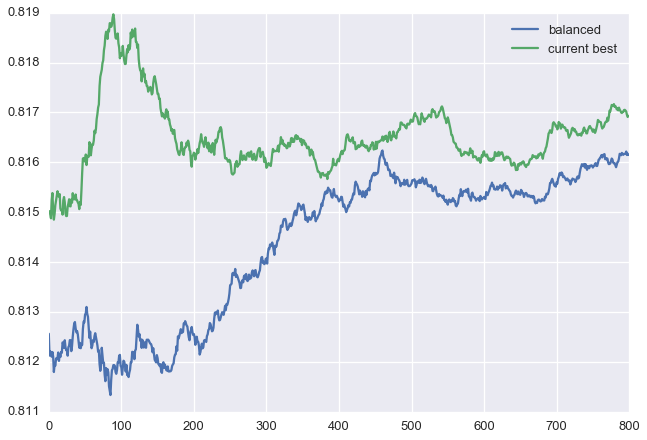

In [51]:
plt.plot(balanced_test_score[200:], label='balanced')
plt.plot(current_best_test_score[200:], label='current best')
plt.legend()

In [52]:
%%time

kwargs = {'n_estimators': 3000, 'class_weight': 'balanced', 'max_features': 7,
          'criterion': 'entropy', 'n_jobs': -1, 'random_state': 42}

rfc = RFC(**kwargs)
rfc.fit(x_train, y_train)

proba = rfc.predict_proba(x_test)[:, 1]
save_to_file(proba, 'simple_3000_7_balanced.csv')

CPU times: user 1min 46s, sys: 870 ms, total: 1min 47s
Wall time: 38.6 s


In [54]:
%%time

kwargs = {'n_estimators': 1000, 'class_weight': 'balanced', 'max_features': 7,
          'criterion': 'entropy', 'n_jobs': -1, 'random_state': 42}

max_depth_test_score = []
max_depth_range = [5, 8, 15, 25, 30, None]

for max_depth in tqdm_notebook(max_depth_range, desc='max_depth'):
    clf = RFC(max_depth = max_depth, **kwargs)
    clf.fit(x_subtrain, y_subtrain)
    max_depth_test_score.append(get_score_list(x_subtest, y_subtest, clf, roc_auc_score))


CPU times: user 2min 46s, sys: 872 ms, total: 2min 46s
Wall time: 1min 12s


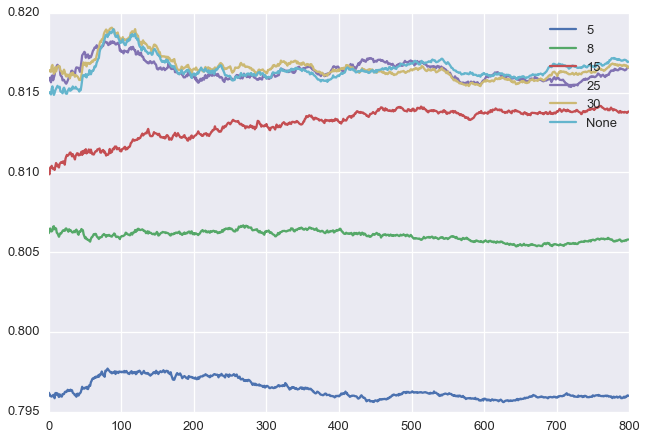

In [57]:
for index, max_depth in enumerate(max_depth_range):
    plt.plot(max_depth_test_score[index][200:], label=str(max_depth))

plt.legend()

In [58]:
%%time

kwargs = {'n_estimators': 1000, 'class_weight': 'balanced', 'max_features': 7,
          'criterion': 'entropy', 'n_jobs': -1, 'random_state': 42}

min_samples_leaf_test_score = []
min_samples_leaf_range = [1, 2, 5, 10]

for min_samples_leaf in tqdm_notebook(min_samples_leaf_range, desc='min_samples_leaf'):
    clf = RFC(min_samples_leaf = min_samples_leaf, **kwargs)
    clf.fit(x_subtrain, y_subtrain)
    min_samples_leaf_test_score.append(get_score_list(x_subtest, y_subtest, clf, roc_auc_score))


CPU times: user 1min 54s, sys: 441 ms, total: 1min 54s
Wall time: 46.1 s


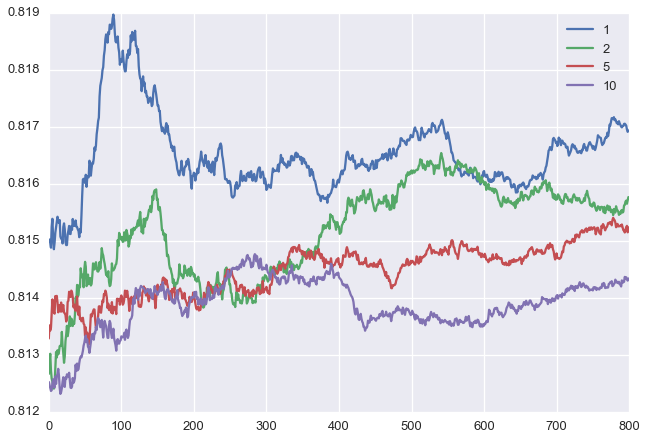

In [59]:
for index, min_samples_leaf in enumerate(min_samples_leaf_range):
    plt.plot(min_samples_leaf_test_score[index][200:], label=str(min_samples_leaf))

plt.legend()

In [60]:
%%time

kwargs = {'n_estimators': 1000, 'class_weight': 'balanced', 'max_features': 7,
          'criterion': 'gini', 'n_jobs': -1, 'random_state': 42}

clf = RFC(**kwargs)
clf.fit(x_subtrain, y_subtrain)
gini_test_score = get_score_list(x_subtest, y_subtest, clf, roc_auc_score)

CPU times: user 22.4 s, sys: 166 ms, total: 22.6 s
Wall time: 11.2 s


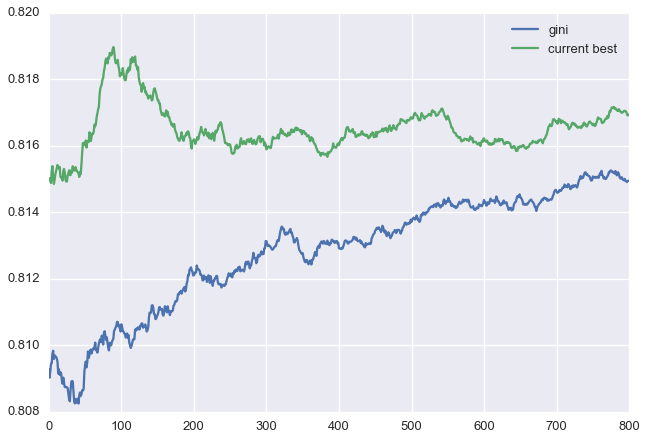

In [61]:
plt.plot(gini_test_score[200:], label='gini')
plt.plot(current_best_test_score[200:], label='current best')
plt.legend()

# Маленькое исследование значимости признаков и влияния моего способа заполнения пропусков

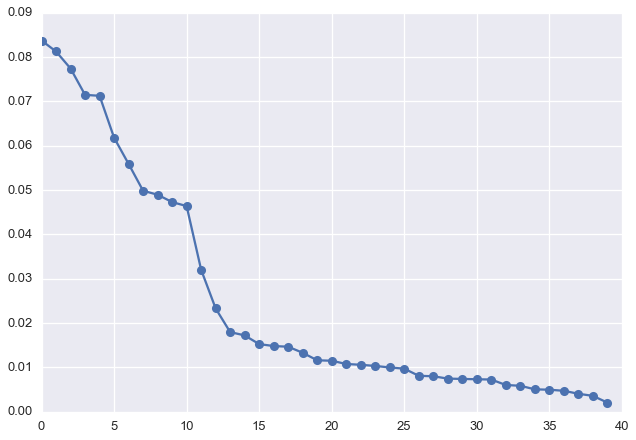

In [64]:
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
plt.plot(importances[indices], '-o')

In [65]:
indices[:15]

array([ 1,  2,  9, 10,  8,  5, 19,  7, 11,  6,  3,  4, 12, 16, 29])

In [72]:
np.array(dfXtrain.columns.tolist())[indices[:11]]

array(['bluebook', 'income', 'travtime', 'home_val', 'age', 'oldclaim',
       'urbanicity_z_Highly Rural/ Rural', 'car_age', 'yoj', 'tif',
       'mvr_pts'], 
      dtype='<U32')

In [78]:
dfXtrain[(dfXtrain.yoj == 0) | (dfXtrain.home_val == 0) | (dfXtrain.income == 0)].shape[0]

3570

In [79]:
dfXtrain.shape[0] - _

4591

In [80]:
dfXtest[(dfXtest.yoj == 0) | (dfXtest.home_val == 0) | (dfXtest.income == 0)].shape[0]

929

In [81]:
dfXtest.shape[0] - _

1212

In [91]:
dfYtrain.set_index('INDEX')[((dfXtrain.yoj == 0) | (dfXtrain.home_val == 0) | (dfXtrain.income == 0))].sum()

P_TARGET_FLAG    1166
dtype: int64

In [92]:
dfYtrain['P_TARGET_FLAG'].sum()

2153

Может быть имеет смысл сделать отдельные классификаторы для объектов с пропусками

# Разные random_state

In [93]:
%%time

kwargs = {'n_estimators': 1000, 'class_weight': 'balanced', 'max_features': 7,
          'criterion': 'entropy', 'n_jobs': -1}

random_state_test_score = []
random_state_range = [42, 0, 100, 200, 300, 400, 500, 600, 700, 800]

for random_state in tqdm_notebook(random_state_range, desc='random_state'):
    clf = RFC(random_state = random_state, **kwargs)
    clf.fit(x_subtrain, y_subtrain)
    random_state_test_score.append(get_score_list(x_subtest, y_subtest, clf, roc_auc_score))


CPU times: user 5min 44s, sys: 1.49 s, total: 5min 45s
Wall time: 2min 16s


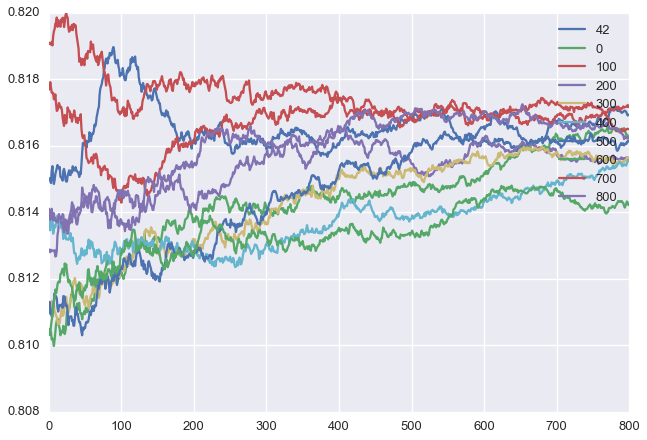

In [94]:
for index, random_state in enumerate(random_state_range):
    plt.plot(random_state_test_score[index][200:], label=random_state)

plt.legend()

Отстой. Похоже, что мы ловили разницу в диапазоне шума. Разница порядка 0.001 -- шум

# Последний поиск на сегодня 

In [96]:
%%time

kwargs = {'n_estimators': 1000, 'class_weight': 'balanced', 'criterion': 'entropy', 'n_jobs': -1, 'random_state': 42}
max_features_test_score_third = []
max_features_range_third = list(range(30, 41))

for max_features in tqdm_notebook(max_features_range_third, desc='max_features'):
    clf = RFC(max_features = max_features, **kwargs)
    clf.fit(x_subtrain, y_subtrain)
    max_features_test_score_third.append(get_score_list(x_subtest, y_subtest, clf, roc_auc_score))


CPU times: user 22min 37s, sys: 1.48 s, total: 22min 39s
Wall time: 6min 53s


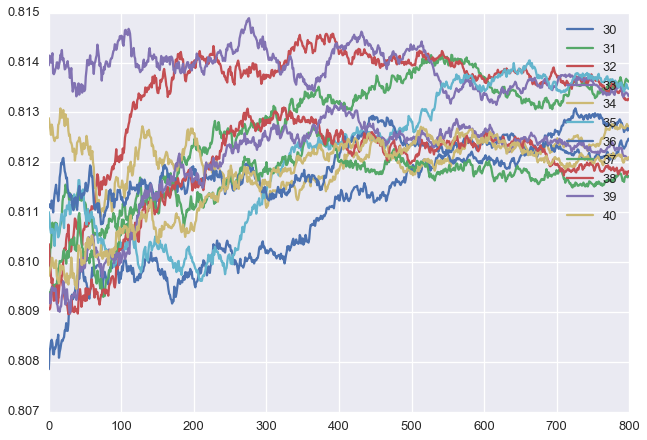

In [97]:
for index, max_features in enumerate(max_features_range_third):
    plt.plot(max_features_test_score_third[index][200:], label=max_features)

plt.legend()

In [100]:
%%time

kwargs = {'n_estimators': 1000, 'class_weight': 'balanced', 'max_features': 31,
          'criterion': 'entropy', 'n_jobs': -1, 'random_state': 42}

clf = RFC(**kwargs)
clf.fit(x_subtrain, y_subtrain)
best_third_test_score = get_score_list(x_subtest, y_subtest, clf, roc_auc_score)

CPU times: user 1min 38s, sys: 114 ms, total: 1min 38s
Wall time: 29 s


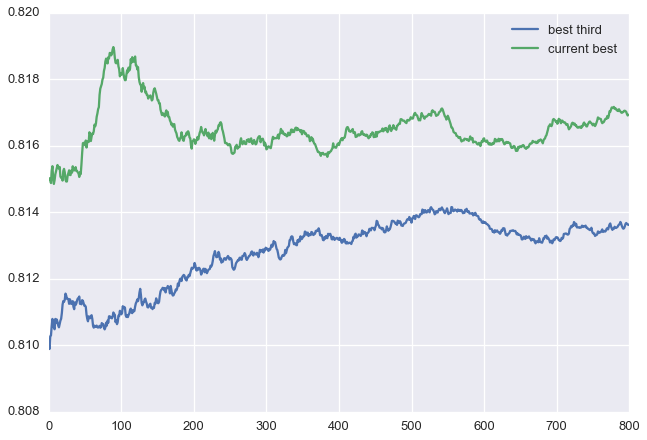

In [101]:
plt.plot(best_third_test_score[200:], label='best third')
plt.plot(current_best_test_score[200:], label='current best')
plt.legend()

Неудача

Попробуем сделать RF 3000 balanced

In [102]:
%%time

kwargs = {'n_estimators': 3000, 'class_weight': 'balanced', 'max_features': 'auto',
          'criterion': 'entropy', 'n_jobs': -1, 'random_state': 42}

rfc = RFC(**kwargs)
rfc.fit(x_train, y_train)

proba = rfc.predict_proba(x_test)[:, 1]
save_to_file(proba, 'simple_3000_balanced.csv')

CPU times: user 1min 30s, sys: 1.51 s, total: 1min 31s
Wall time: 1min 9s
